# **Oolala Cabs Analysis** 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from datetime import datetime as dt

%matplotlib inline

In [2]:
df = pd.read_excel('olala cabs case study.xlsx')

### Getting familiar with Dataset

In [3]:
df.head()

,order_id,status,customer_id,driver_id,pickup_time,start_time,drop_time,pickup_loc,drop_loc,travel_distance,cancelled_by
0,4824156,4,305169,10.0,2019-01-02 13:10:13,2019-01-02 13:32:19,2019-01-02 14:04:25,Andheri West,Juhu,1.70,NaN
1,4826642,4,498734,10.0,2019-01-02 16:45:56,2019-01-02 17:01:15,2019-01-02 21:08:13,Andheri East,Kalyan,47.03,NaN
2,4830467,4,125080,10.0,2019-01-03 11:25:48,2019-01-03 11:30:54,2019-01-03 13:02:43,Andheri West,Bandra West,7.93,NaN
3,4832599,4,107008,10.0,2019-01-03 14:50:58,2019-01-03 14:37:06,2019-01-03 15:09:52,Juhu,Jogeshwari West,6.35,NaN
4,4833444,4,278997,10.0,2019-01-03 15:36:29,2019-01-03 15:42:35,2019-01-03 17:29:24,Jogeshwari West,Saki Naka,8.48,NaN


In [5]:
df.dtypes

order_id                    int64
status                      int64
customer_id                 int64
driver_id                 float64
pickup_time        datetime64[ns]
start_time         datetime64[ns]
drop_time          datetime64[ns]
pickup_loc                 object
drop_loc                   object
travel_distance           float64
cancelled_by               object
dtype: object

In [6]:
df.shape

(20205, 11)

In [7]:
df['pickup_time'].describe() # Only 2 weeks of Cab data is available

count                   20205
unique                  19781
top       2019-01-01 10:00:00
freq                        3
first     2019-01-01 00:15:08
last      2019-01-14 23:54:09
Name: pickup_time, dtype: object

In [8]:
df.isnull().mean() #start time, drop time, driver_id, cancelled by all are nullable columns in different cases

order_id           0.000000
status             0.000000
customer_id        0.000000
driver_id          0.091314
pickup_time        0.000000
start_time         0.220638
drop_time          0.224350
pickup_loc         0.000000
drop_loc           0.000000
travel_distance    0.000000
cancelled_by       0.775600
dtype: float64

In [9]:
df.status.value_counts(normalize=True) # 77:23 ratio 

4    0.774462
5    0.225538
Name: status, dtype: float64

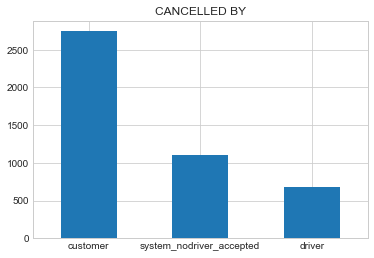

In [221]:
#Plot for cancel distribution
df.cancelled_by.value_counts().plot.bar(rot=0,title='CANCELLED BY')

# Data Cleaning

## Identifying Data Issues

In [10]:
df.duplicated().sum() #37 complete duplicate rows are identified, since order_id is a unique_key for ride this is a data issue

37

In [11]:
df.loc[df.drop_loc=='Airport',:].duplicated().sum() 

0

In [12]:
# Even for cancelled rides,cases are observed which had start and drop times, as confirmed by business this is a data issue
df.loc[(df.status == 5) & (~df.drop_time.isnull() | ~df.start_time.isnull()),'order_id'].shape

(99,)

In [19]:
df.loc[(df.status == 5) & (~df.drop_time.isnull() | ~df.start_time.isnull()),'drop_loc'].value_counts() 
# Only 1 case of Airport

Churchgate         11
Bandra East         5
Kandiwali West      4
Antop Hill          4
Andheri West        4
Kandivali East      3
Powai               3
Vikhroli            3
Lower Parel         3
Andheri East        3
Bandra West         3
Dadar               3
Malad East          3
Jogeshwari West     2
Purna               2
Byculla             2
Ghatkopar           2
Kurla               2
Jogeshwari East     2
Aarey               2
Saki Naka           2
Vile Parle East     2
Malad West          2
Marol               2
Sanpada             2
Sonale              2
Majiwada            1
Nerul               1
Mulund              1
Kalyan              1
Mumbai Central      1
Rabale              1
Airport             1
Mira Bhayander      1
Govandi             1
Vashi               1
Pimplas             1
Dahisar West        1
Versova             1
Kasheli             1
Dongri              1
Shivai Nagar        1
Boriwali East       1
Juhu                1
Padgha              1
Ovale     

In [13]:
df['pickup_hour'] = df.pickup_time.dt.hour # Since data is of 2 weeks this is the only thing that can possibly help

In [14]:
df.cancelled_by.value_counts() # 3 types of cancellation are present, system_nodriver_accepted should not have any driver_id

customer                    2748
system_nodriver_accepted    1098
driver                       688
Name: cancelled_by, dtype: int64

In [16]:
df.loc[(df.status == 5) & (df.cancelled_by == 'system_nodriver_accepted'),'driver_id'].value_counts(dropna=False)
# This also looks like Data issue as all should have been NAN

NaN         1065
 20468.0       2
 21357.0       2
 22414.0       2
 20670.0       1
 24074.0       1
 13091.0       1
 3649.0        1
 13285.0       1
 23309.0       1
 12692.0       1
 2013.0        1
 10276.0       1
 8265.0        1
 21782.0       1
 25869.0       1
 15791.0       1
 24758.0       1
 16637.0       1
 5945.0        1
 23267.0       1
 4713.0        1
 10324.0       1
 2600.0        1
 23318.0       1
 6011.0        1
 10008.0       1
 3689.0        1
 11675.0       1
 25020.0       1
 10.0          1
Name: driver_id, dtype: int64

In [18]:
df.loc[(df.status == 5) & (df.cancelled_by == 'system_nodriver_accepted') & (~df.driver_id.isnull()),['start_time','drop_time']]
# As start and drop_times are NAN so these are cancelled but probably by driver and not by system

,start_time,drop_time
6,NaT,NaT
910,NaT,NaT
1190,NaT,NaT
1822,NaT,NaT
1856,2019-01-08 17:20:09,NaT
2509,NaT,NaT
3245,NaT,NaT
3315,NaT,NaT
5123,NaT,NaT
5997,NaT,NaT


In [22]:
((df.status == 5) & (df.cancelled_by == 'system_nodriver_accepted') & (~df.driver_id.isnull())).sum()

33

In [31]:
df.loc[(df.status == 5) & (df.cancelled_by == 'system_nodriver_accepted') & (~df.driver_id.isnull()) & (df.drop_loc == 'Airport')].shape

(17, 12)

In [48]:
#After business has confirmed that status = 4 is for successful rides, let's check if this has errorneous data
df.loc[df.status == 4,'cancelled_by'].value_counts()
# 7 error records

driver      4
customer    3
Name: cancelled_by, dtype: int64

In [50]:
#Similar check as above for Cancelled Cabs
df.loc[df.status == 5,'cancelled_by'].value_counts(dropna=False)
# 30 orders doesn't have cancelled_by for cancelled rides

customer                    2743
system_nodriver_accepted    1098
driver                       682
NaN                           30
Name: cancelled_by, dtype: int64

In [52]:
#Let's check if any such case for drop_loc = Airport
df.loc[(df.status == 5) & (df.drop_loc == 'Airport'),'cancelled_by'].value_counts(dropna=False)
# No such case for Airport, so these can be dropped

driver                      182
system_nodriver_accepted     44
customer                      6
Name: cancelled_by, dtype: int64

In [53]:
df.loc[(df.status == 5) & (df.cancelled_by.isnull()),:]

,order_id,status,customer_id,driver_id,pickup_time,start_time,drop_time,pickup_loc,drop_loc,travel_distance,cancelled_by,pickup_hour
18383,4813846,5,577751,NaN,2019-01-01 10:00:00,NaT,NaT,Saki Naka,Vashi,20.04,NaN,10
18384,4813847,5,577751,NaN,2019-01-01 10:00:00,NaT,NaT,Saki Naka,Vashi,20.04,NaN,10
18385,4815914,5,577751,NaN,2019-01-01 10:00:00,NaT,NaT,Saki Naka,Vashi,19.67,NaN,10
18514,4820605,5,577751,NaN,2019-01-02 10:00:00,NaT,NaT,Saki Naka,Vashi,19.67,NaN,10
18515,4820606,5,577751,NaN,2019-01-02 10:00:00,NaT,NaT,Saki Naka,Vashi,20.03,NaN,10
18648,4827594,5,577751,NaN,2019-01-03 10:00:00,NaT,NaT,Saki Naka,Vashi,20.36,NaN,10
18649,4827595,5,577751,NaN,2019-01-03 10:00:00,NaT,NaT,Saki Naka,Vashi,19.67,NaN,10
18771,4834962,5,577751,NaN,2019-01-04 10:00:00,NaT,NaT,Saki Naka,Vashi,19.67,NaN,10
18772,4834963,5,577751,NaN,2019-01-04 10:00:00,NaT,NaT,Saki Naka,Vashi,22.13,NaN,10
18921,4840740,5,275475,NaN,2019-01-05 09:30:00,NaT,NaT,Padgha,Ghatkopar,44.44,NaN,9


### Handling Issues in Data

- **Duplicates**: **37** duplicate rows were found, these can be dropped as all order_id's are unique and complete row duplicates are of no value

- **Status 4 but cancelled_by populated**: **7** such orders, this are successfull rides unless is justified by business and should be reclassified as such, but dropping for simplicity.

- **Status 5 but NAN in cancelled_by**: **30** such rides with no start and drop time, so these are cancelled. These can be replaced with **Mode** of cancelled_by but since Airport is not impacted in this, we can also drop these.

- **Cancelled rides with start and drop times**: **99** such rides were identified, which is less than **0.5%** of our data and drop_loc of Airport has only one such scenario, this shouldn't have an impact on our analysis and these could be dropped [Business has confirmed this as well]

- **Cancelled as system_nodriver_accepted but has driver_id**: **33** such rides are identified, these are probably cancelled as start and drop times were absent but may be cancelled by driver, **17** impact our drop_loc of Airport. **We'll drop these 33 for now but if margins of analysis are low, we'll replace these cancellation as by driver and recheck**. Better decision can be taken by domain knowledge and Data Capture knowledge


In [32]:
df.drop_duplicates(inplace=True)

In [57]:
df.shape

(20168, 12)

In [42]:
df1 = df.loc[~((df.status == 5) & (~df.drop_time.isnull() | ~df.start_time.isnull()))]

In [59]:
cabs = df1.loc[~((df1.cancelled_by == 'system_nodriver_accepted') & (~df1.driver_id.isnull()))]

In [65]:
cabs = cabs.loc[~((cabs.status == 4) & (~cabs.cancelled_by.isnull()))]

In [66]:
cabs = cabs.loc[~((cabs.status == 5) & (cabs.cancelled_by.isnull()))]

In [67]:
cabs.shape #Finl cleaned data set 

(20000, 12)

# Are drivers cancelling Airport Trips ?

In [69]:
sb.set_style('whitegrid')

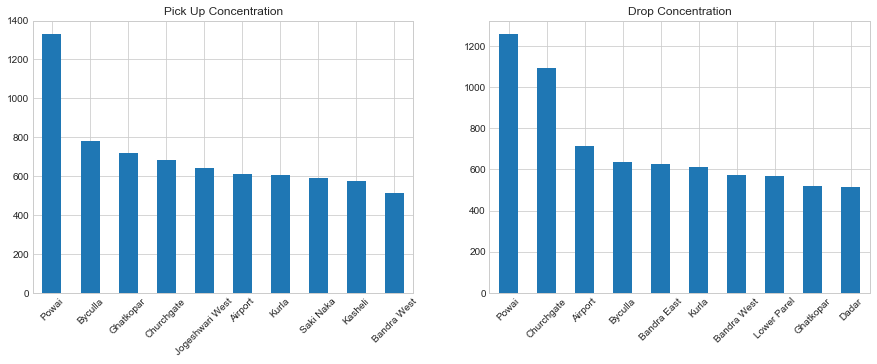

In [224]:
plt.subplot(1,2,1)
cabs['pickup_loc'].value_counts()[:10].plot.bar(title='Pick Up Concentration',figsize=(15,5),rot=45)
plt.subplot(1,2,2)
cabs['drop_loc'].value_counts()[:10].plot.bar(title='Drop Concentration',rot=45)

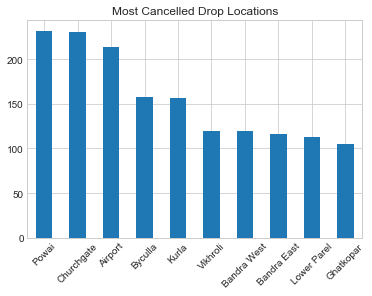

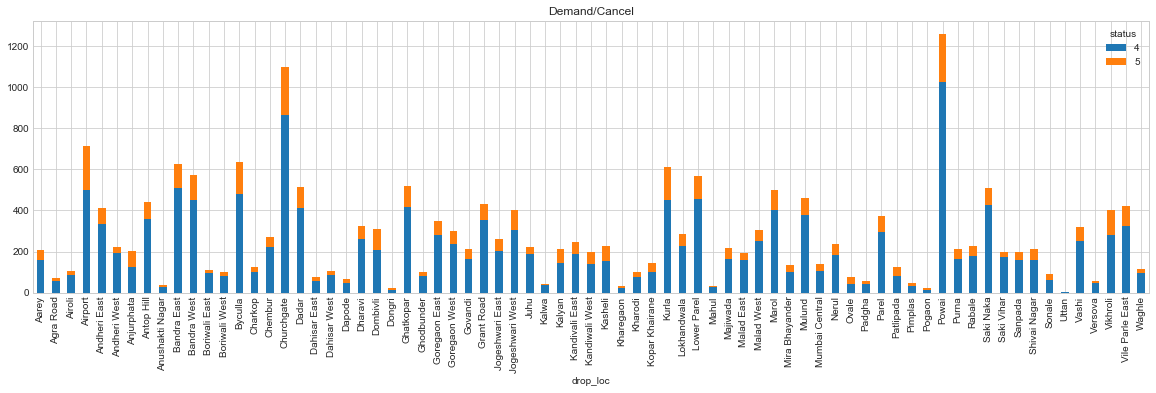

In [229]:
cabs.loc[~cabs.cancelled_by.isnull(),'drop_loc'].value_counts()[:10].plot.bar(title='Most Cancelled Drop Locations',rot=45)
pd.crosstab(cabs.drop_loc,cabs.status).plot.bar(stacked=True,title='Demand/Cancel',rot=90,figsize=(20,5))

### Since we know 60% of cancellations are done by customer, let's see how this changes wrt drop locations and driver

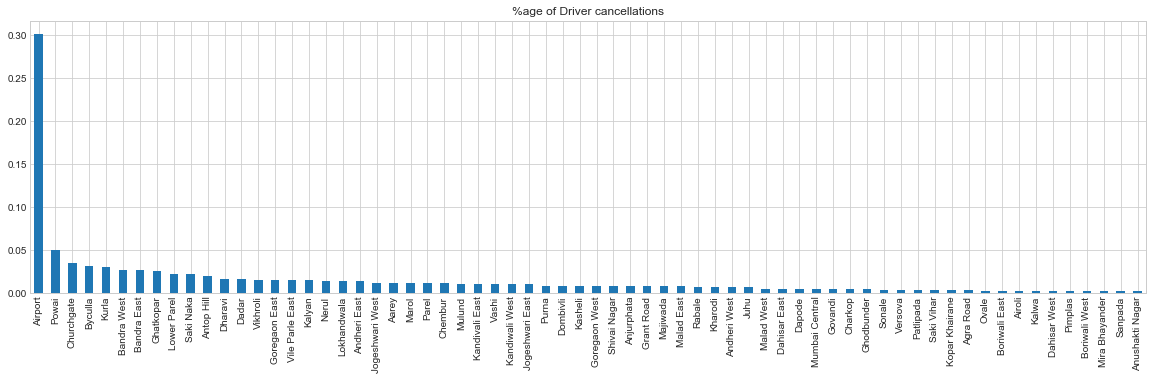

In [230]:
fig,ax = plt.subplots(figsize=(20,5))
cabs.loc[cabs.cancelled_by == 'driver','drop_loc'].value_counts(normalize=True).plot.bar(title='%age of Driver cancellations')

### But it doesn’t conclude if only drivers are cancelling Airport rides!! Let's check below

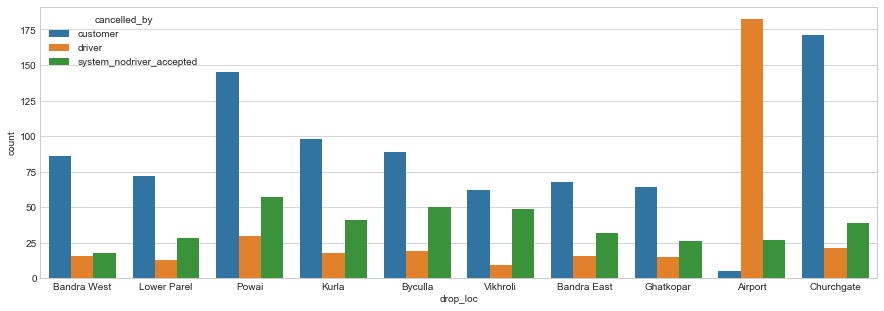

In [100]:
fig,ax = plt.subplots(figsize=(15,5))
a = list(cabs.loc[~cabs.cancelled_by.isnull(),'drop_loc'].value_counts()[:10].index)
sb.countplot(x=cabs.loc[cabs.drop_loc.isin(a),'drop_loc'],hue=cabs.cancelled_by,ax=ax)

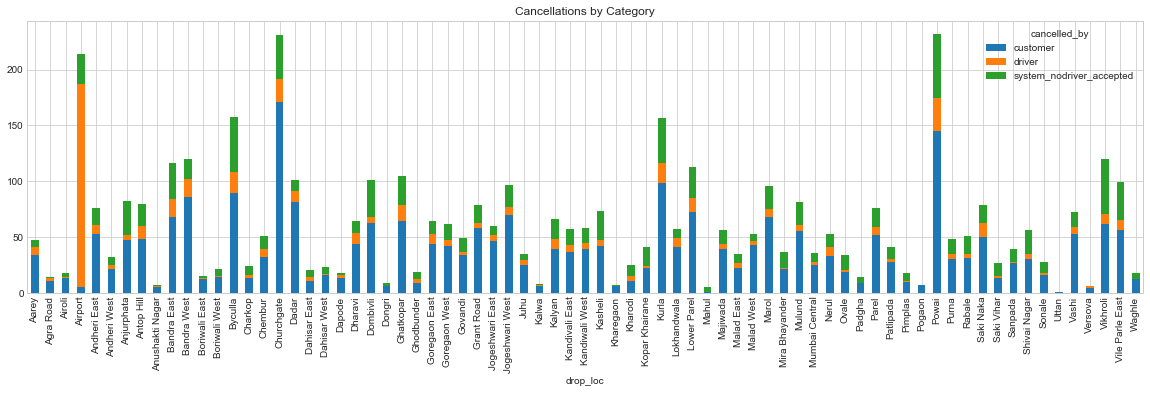

In [231]:
pd.crosstab(cabs.drop_loc,cabs.cancelled_by).plot.bar(stacked=True, figsize = (20,5),title='Cancellations by Category')

# Why do Airport trips are getting Cancelled by drivers ?

In [131]:
cabs['pickup_day'] = cabs.pickup_time.dt.day #To check for unusual events

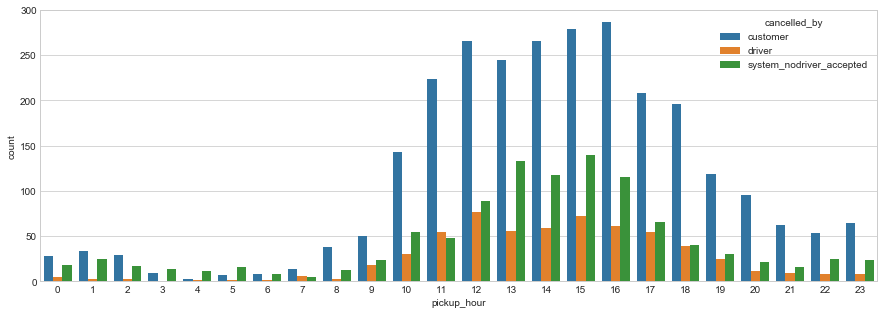

In [153]:
fig,ax = plt.subplots(figsize=(15,5))
sb.countplot(x=cabs.pickup_hour,hue=cabs.cancelled_by,ax=ax)

### Check for unusual no. of cancellations during any day

Text(0.5,1,'Airport Cancellations by drivers per day')

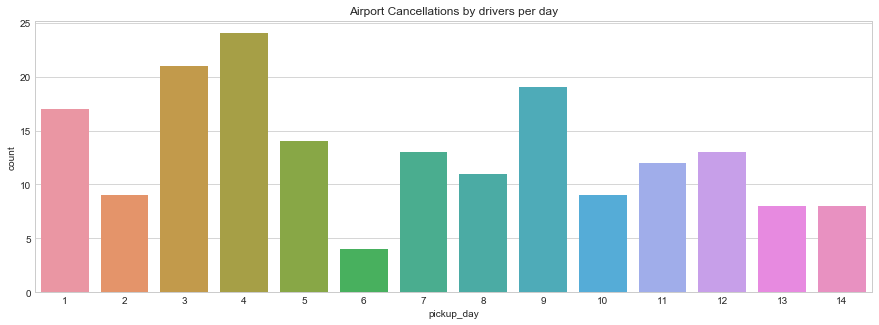

In [235]:
fig,ax = plt.subplots(figsize=(15,5))
sb.countplot(x=cabs.loc[(cabs.cancelled_by == 'driver') & (cabs.drop_loc == 'Airport'),'pickup_day'],ax=ax)
ax.set_title('Airport Cancellations by drivers per day')

### Furthur root cause analysis

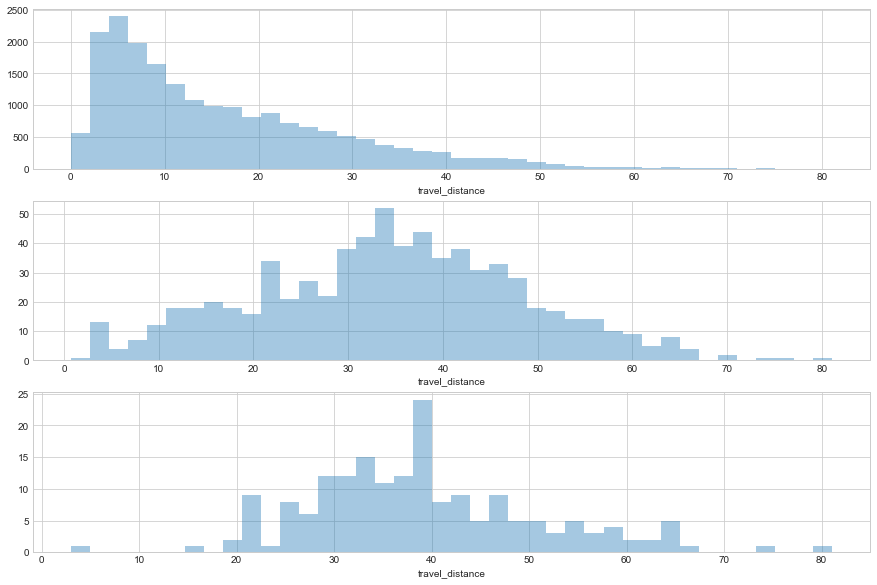

In [236]:
fig,ax1 = plt.subplots(figsize=(15,10))

plt.subplot(3,1,1)
sb.distplot(cabs['travel_distance'],kde=False,bins=40)

plt.subplot(3,1,2)
sb.distplot(cabs.loc[cabs.drop_loc=='Airport','travel_distance'],kde=False,bins=40)

plt.subplot(3,1,3)
sb.distplot(cabs.loc[(cabs.drop_loc=='Airport')&(cabs.cancelled_by=='driver'),'travel_distance'],kde=False,bins=40)

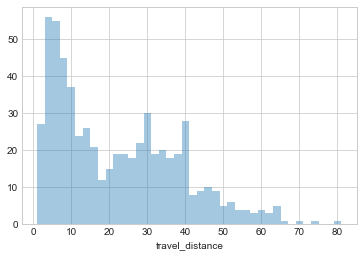

In [168]:
sb.distplot(cabs.loc[cabs.cancelled_by=='driver','travel_distance'],kde=False,bins=40)

### Travel Distance of trips looks like suggestive of something

In [179]:
pd.cut(cabs.travel_distance,bins=20).value_counts()

(4.062, 8.114]      4381
(8.114, 12.166]     2977
(-0.071, 4.062]     2712
(12.166, 16.218]    2067
(16.218, 20.27]     1790
(20.27, 24.322]     1582
(24.322, 28.374]    1260
(28.374, 32.426]     982
(32.426, 36.478]     692
(36.478, 40.53]      539
(40.53, 44.582]      329
(44.582, 48.634]     318
(48.634, 52.686]     169
(52.686, 56.738]      73
(56.738, 60.79]       53
(60.79, 64.842]       42
(64.842, 68.894]      16
(68.894, 72.946]      12
(72.946, 76.998]       5
(76.998, 81.05]        1
Name: travel_distance, dtype: int64

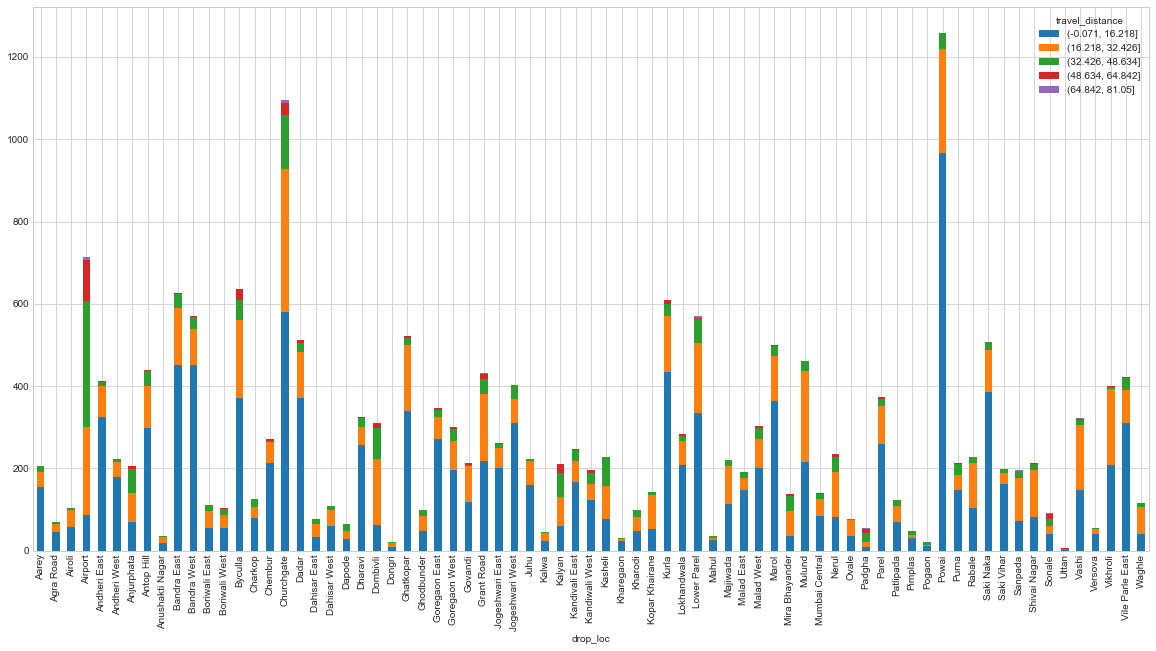

In [184]:
pd.crosstab(cabs.drop_loc,pd.cut(cabs.travel_distance,bins=5)).plot.bar(stacked=True,figsize=(20,10))

Above tells us, that for **Airport** 
 -  More than 85% of trips are of > 16KM
 -  More than 55% of trips are of > 32KM

**Which is way more than for any other drop location**


In [194]:
cabs['trip_time'] = (cabs.drop_time - cabs.start_time).dt.seconds/60

In [198]:
cabs.trip_time.describe()

count    15608.000000
mean       110.099412
std         75.954605
min          1.000000
25%         58.833333
50%         91.800000
75%        139.833333
max        884.366667
Name: trip_time, dtype: float64

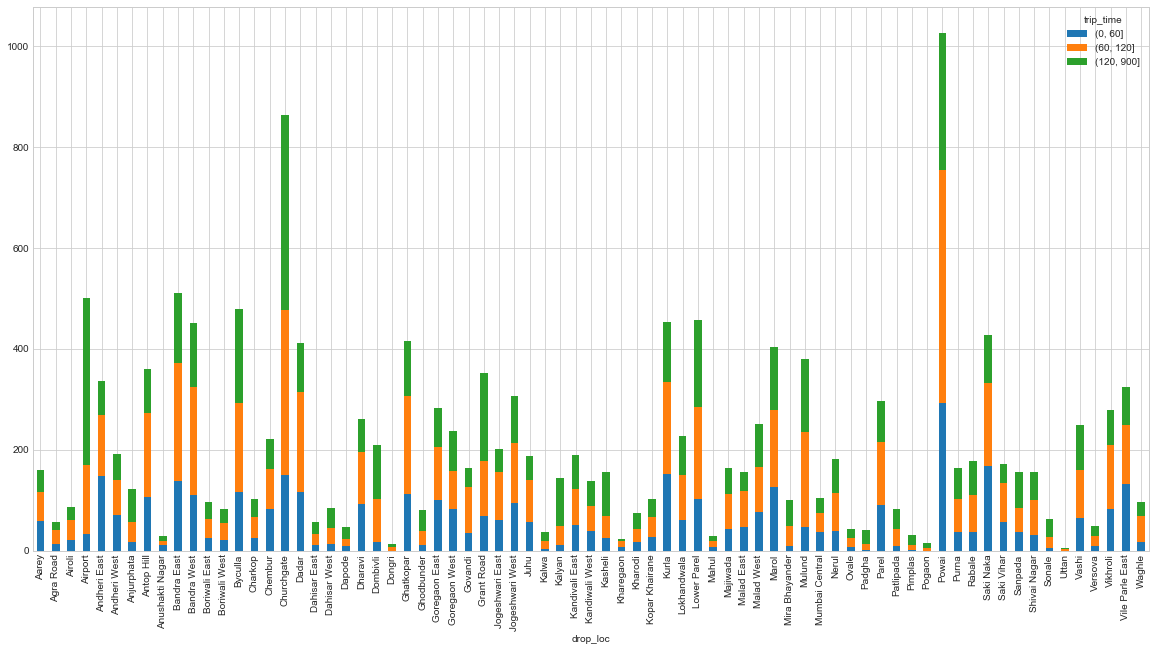

In [206]:
pd.crosstab(cabs.drop_loc,pd.cut(cabs.trip_time,precision=0,bins=[0,60,120,900])).plot.bar(stacked=True,figsize=(20,10))

### More than 60% of trips to Airport have taken more than 2 hour to complete

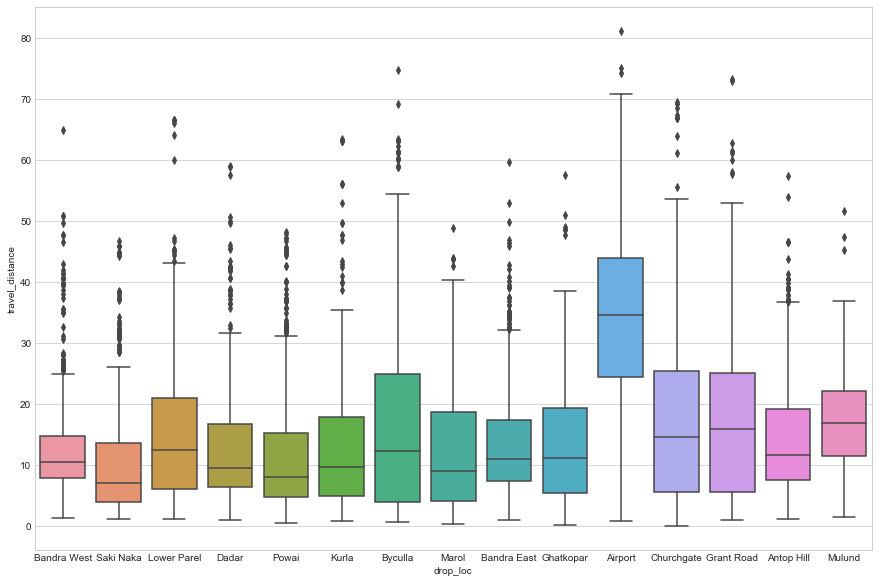

In [217]:
most_rides = list(cabs.drop_loc.value_counts()[:15].index)
fig,ax1 = plt.subplots(figsize=(15,10))
sb.boxplot(x=cabs.loc[cabs.drop_loc.isin(most_rides),'drop_loc'],y=cabs.travel_distance,ax=ax1)

# **Conclusion:**

### Trips to Airport are getting cancelled by our Drivers significantly and the reason for their dislike to Airport trips is way more travel distance and journey time experienced in past as compared to other locations
